In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import pickle
import math
import random
import numpy as np
import itertools
import bisect
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
import time
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, \
    confusion_matrix, f1_score, average_precision_score
from iforest import IsolationTreeEnsemble, find_TPR_threshold
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from k_means_constrained import KMeansConstrained
from sklearn.metrics import mean_squared_error 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['diagnosis'] = cancer.target
df.loc[df.diagnosis==0,'diagnosis'] = -1
df.loc[df.diagnosis==1,'diagnosis'] = 0
df.loc[df.diagnosis==-1,'diagnosis'] = 1
df.to_csv("cancer.csv", index=False)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [3]:
def plot_anomalies(X, y, sample_size=256, n_trees = 100, 
                   desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)
    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    print(f"fit time {fit_time:3.2f}s")
    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
    print(f"score time {score_time:3.2f}s")
    if desired_TPR is not None:
        threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)
        print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    confusion = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]
    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)
    print('FScore : ',F1 )
    return None
class ANN:
    def __init__(self, X, Y, X_test, Y_test, hidden_nodes=12, learninig_rate=0.1, epochs=500):
        self.X = X
        self.Y = Y[:, None]
        self.X_test = X_test
        self.Y_test = Y_test

        # defining parameters

        np.random.seed(4)
        self.input_nodes = len(X[0])     # number of features in the training data
        self.hidden_nodes = hidden_nodes
        self.output_npdes = self.Y.shape[1]
        self.learning_rate = learninig_rate

        # initializing the weights for our network

        self.w1 = 2 * np.random.random((self.input_nodes, self.hidden_nodes)) - 1
        self.w2 = 2 * np.random.random((self.hidden_nodes, self.output_npdes)) - 1

        self.train(epochs)  # Since we have to train our model for many times we here pass epochs count
        self.test()
    
    def sigmoid(self,X):
        return (1 / (1 + np.exp(-X)))
    def sigmoid_prime(self, X):
        return X * (1 - X)



    def train(self, epochs):
        for e in range(epochs):
            # FORWARDPROPAGATION
            l1 = self.sigmoid(np.dot(self.X, self.w1))
            # in between hidden and output
            l2 = self.sigmoid(np.dot(l1, self.w2))

            # BACKPROPAGATION
            # Network error (True value - Predicted value)

            error = self.Y - l2

            # error for each of the layers

            l2_delta = error * self.sigmoid_prime(l2)
            l1_delta = l2_delta.dot(self.w2.T) * self.sigmoid_prime(l1)

            self.w2 = np.add(self.w2, l1.T.dot(l2_delta) * self.learning_rate)
            self.w1 = np.add(self.w1, self.X.T.dot(l1_delta) * self.learning_rate)

#         print('Error : ', (abs(error)).mean())

    # testing and evaluation


    def test(self):
        correct = 0
        pred_list = []
        l1 = self.sigmoid(np.dot(self.X_test, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))

        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.Y_test[i]:
                correct += 1

            pred_list.append(pred)
#         print('Test Accuracy : ', ((correct / len(Y_test)) * 100), '%')



        precision, recall,fscore, support =  precision_recall_fscore_support(Y_test, pred_list)

        tn, fp, fn, tp = confusion_matrix(Y_test, pred_list).ravel()
#         print('True Nagative', tn)
#         print('False Positive', fp)
#         print('False Negative', fn)
#         print('True Positive', tp)

        total = tn + tp + fn + fp

#         print('Test Accuracy : ', (tn + tp)/total)
#         print('FScore : ', (fscore[0]+fscore[1])/2)
        return (fscore[0]+fscore[1])/2

    def fm_test(self,X,Y):
        correct = 0
        pred_list = []
        l1 = self.sigmoid(np.dot(X, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))

        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.Y[i]:
                correct += 1

            pred_list.append(pred)
        precision, recall,fscore, support =  precision_recall_fscore_support(Y, pred_list)

        tn, fp, fn, tp = confusion_matrix(Y, pred_list).ravel()
        return (fscore[0]+fscore[1])/2

# AD with isolation forest 

In [4]:
datafile = 'cancer.csv'
targetcol = 'diagnosis'
sample_size = int(5)
n_trees = int(300)
desired_TPR = int(80)
desired_TPR /= 100.0

X, y = df.drop(targetcol, axis=1), df[targetcol]
plot_anomalies(X, y, sample_size=sample_size, n_trees=n_trees, desired_TPR=desired_TPR, bins=15)

fit time 0.03s
score time 0.01s
Computed 0.8000 TPR threshold 0.4880 with FPR 0.1092
FScore :  0.7323232323232323


# AD with ANN 

In [5]:
data = pd.read_csv('data.csv')
del data['Unnamed: 32']
X = data.iloc[:, 2:].values       
Y = data.iloc[:, 1].values

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state= 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
nn = ANN(X_train, Y_train, X_test, Y_test)

In [6]:
ANN.fm_test(nn,X_test, Y_test)

0.9686870536531771

# Some usefull function for Explainable AI 


In [7]:
def calculatShapley(cFunction,coalition,nPlayer):
    coalition=list(coalition)
    for i in range(0,len(coalition)):
        coalition[i]=list(coalition[i])

    stat = time.time()
#     print("start calculate shapley:")
    shapley_values = []
    for i in range(len(nPlayer)):
        shapley = 0
        for j in coalition:
            if i not in j:
                j=list(j)
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = coalition.index(j)
                k = coalition.index(Cui)
                temp = float(float(cFunction[k]) - float(cFunction[l])) *\
                           float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
                shapley += temp
                # if i is 0:
                #     print j, Cui, cmod, n-cmod-1, characteristic_function[k], characteristic_function[l], math.factorial(cmod), math.factorial(n - cmod - 1), math.factorial(n)

        cmod = 0
        Cui = [i]
        k = coalition.index(Cui)
        temp = float(cFunction[k]) * float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
        shapley += temp

        shapley_values.append(shapley)
    end_time = time.time()
    T_time = end_time-stat
#     print(f"time {time_cacul:3.2f}s")
    return (shapley_values)



def getcoaltionlist(n):
    coalition=[]
    singles = tuple([i for i in range(n)])
    for i in range(1, n+1):
        for p in itertools.combinations(singles, i):
            coalition.append(p)
            # if i==2:
            #     print(p)
    return coalition

def ApproShap(ListOfSampling,characteristicF,playerList,counter):
    sha=[0 for i in range(len(playerList))]
    for ob in ListOfSampling:
        k=0
        for i in ob:# ob is sequence of player id from 0 to N
            pre_i_ob=calculatePre_i(ob,i)#calculate pre^i(ob)
#             print("k",k)
            x_ob=calculateX(pre_i_ob,i,characteristicF[k])
            sha[i]=sha[i]+x_ob
        k=k+1

    sha=[x/np.shape(ListOfSampling)[0] for x in sha]
    return sha

def randomChose(probability,listPlayer):
    np.random.seed(0)
    p = np.array()
    for k in list:
        np.append(p,probability,axis=0)
    index = np.random.choice(listPlayer, p=p.ravel())
    return listPlayer[index]

def permutation(list,count): #probability: 1/n!, count: sampling size
    sampling=[]
    for k in range(0,count):
        templist = list.copy()
        random.shuffle(list)
        sampling.append(templist)
    return sampling



def calculatePre_i(ob,i):
    result=[]
    for k in range(0,len(ob)):
        if ob[k]!=i:
            result.append(ob[k])
        else :
            break

    return result

def calculateX(ob,i,characteristicF):
    new_ob=ob.copy()
    new_ob.append(i)
   # print("new_ob,",new_ob)
   # print("ob",ob)
    result = characteristicFunction(new_ob,characteristicF)-characteristicFunction(ob,characteristicF)
    return result

def characteristicFunction(ob,characteristicF):
    result=0
    #print("ob",ob)
    if ob==None:
        return result
    else:
        result=characteristicF[len(ob)-1]
    return result

def calculatShapley(cFunction,coalition,nPlayer):
    coalition=list(coalition)
    for i in range(0,len(coalition)):
        coalition[i]=list(coalition[i])

    stat = time.time()
    shapley_values = []
    for i in range(len(nPlayer)):
        shapley = 0
        for j in coalition:
            if i not in j:
                j=list(j)
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = coalition.index(j)
                k = coalition.index(Cui)
                temp = float(float(cFunction[k]) - float(cFunction[l])) *\
                           float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
                shapley += temp
        cmod = 0
        Cui = [i]
        k = coalition.index(Cui)
        temp = float(cFunction[k]) * float(math.factorial(cmod) * math.factorial(len(nPlayer) - cmod - 1)) / float(math.factorial(len(nPlayer)))
        shapley += temp

        shapley_values.append(shapley)
    end_time = time.time()
    T_time = end_time-stat
    return (shapley_values)

def getcoaltionlist(n):
    coalition=[]
    singles = tuple([i for i in range(n)])
    for i in range(1, n+1):
        for p in itertools.combinations(singles, i):
            coalition.append(p)
    return coalition

def getgroup_level(X,group):
    X_n = np.array(X)
    X_n = X_n
#     X_n = X_n[:,group.extend([0]*len(X) - 3)]
    X_n = X_n[:,group]
    return X_n

    
    return X_n

def shap_2level(X_n, idx_dic,player_2level):
    Phi_2Level = []
    coalition_2level = getcoaltionlist(number_group)
    for pair in coalition_2level:
        idx = [i for i in pair]
        idx_2=[]
        for j in idx:
            idx_2.extend(idx_dic[j])
        idx_2 = np.array(idx_2).reshape(-1,)
        x_selected = X_n[:,idx_2]
        pr = pr_anomalies(x_selected,y,n_trees=n_trees,desired_TPR=desired_TPR)
        Phi_2Level.append(pr)
    Shap_2level = calculatShapley(Phi_2Level,coalition_2level,player_2level)
    return Shap_2level 

def get_Phi_coalition(idx_dic):
    coalition_={}
    X, y = df.drop(targetcol, axis=1), df[targetcol]
    Phi_1level = {}
    #     idx_map = {v: k for k,v in enumerate(l1_group)}
    start_time = time.time()
    for i in range(number_group):
        coalition_[i] = getcoaltionlist(len(idx_dic[i]))
        l1_group = idx_dic[i]
        df_list2=np.array(X)
        Tm1 = df_list2[:,0:30].copy()
        Phi_=[]
        c = Tm1.copy()
    #     print(c.shape)
        for k in range(0,len(coalition_[i])):
            pl_1level = c.copy()
            diff_2 = set(l1_group) ^ set(coalition_[i][k])
    #         print(diff)
    #         diff_2=[idx_map[x] for x in diff]
#             print(diff_2)
            if (len(diff_2) != 0):
                pl_1level[:,list(diff_2)] = np.zeros(np.shape(pl_1level[:, list(diff_2)]))
#                 print("k",k)
                pr = pr_anomalies(pl_1level,y,n_trees=n_trees,desired_TPR=desired_TPR)
            else:
                pr = pr_anomalies(c,y,n_trees=n_trees,desired_TPR=desired_TPR)   
            Phi_ .append(pr)
        Phi_1level[i]=Phi_
    return Phi_1level
def ApproShap_shou(ListOfSampling,characteristicF,playerList,counter):
    sha=[0 for i in range(len(playerList))]
    shaOld=[0 for i in range(len(playerList))]
    errors=[]
    for ob in ListOfSampling:
        k=0
        shaNew=[0 for i in range(len(playerList))]
        for i in ob:# ob is sequence of player id from 0 to N
            pre_i_ob=calculatePre_i(ob,i)#calculate pre^i(ob)
#             print("k",k)
            x_ob=calculateX(pre_i_ob,i,characteristicF[k])
            sha[i]=sha[i]+x_ob
            shaNew[i]=x_ob
            print("::",shaNew)
        k=k+1
        
        tempError=0
        for i in range(0,len(shaNew)):
            tempError= tempError+ np.sqrt(shaNew[i]-shaOld[i])
        print("!!!!",tempError)
        errors.append(tempError)
        shaOld=shaNew.copy()
    sha=[x/np.shape(ListOfSampling)[0] for x in sha]
    return errors

def generateCoalitions(n,total_n): 
    Total_coalitions = []
    for i in range(total_n):
        coalitions = np.random.randint(0,31,n)
        Total_coalitions.append(coalitions)
    return Total_coalitions
        

# cluster for coalitions 

In [8]:
import random

class ANN:
    def __init__(self, X, Y, X_test, Y_test, hidden_nodes=12, learninig_rate=0.1, epochs=500):
        self.X = X
        self.Y = Y[:, None]
        self.X_test = X_test
        self.Y_test = Y_test

        # defining parameters

        np.random.seed(4)
        self.input_nodes = len(X[0])     # number of features in the training data
        self.hidden_nodes = hidden_nodes
        self.output_npdes = self.Y.shape[1]
        self.learning_rate = learninig_rate

        # initializing the weights for our network

        self.w1 = 2 * np.random.random((self.input_nodes, self.hidden_nodes)) - 1
        self.w2 = 2 * np.random.random((self.hidden_nodes, self.output_npdes)) - 1

        self.train(epochs)  # Since we have to train our model for many times we here pass epochs count
        
        self.test()
    def sigmoid(self,X):
        return (1 / (1 + np.exp(-X)))
    def sigmoid_prime(self, X):
        return X * (1 - X)



    def train(self, epochs):
        for e in range(epochs):
            # FORWARDPROPAGATION
            l1 = self.sigmoid(np.dot(self.X, self.w1))
            # in between hidden and output
            l2 = self.sigmoid(np.dot(l1, self.w2))

            # BACKPROPAGATION
            # Network error (True value - Predicted value)

            error = self.Y - l2

            # error for each of the layers

            l2_delta = error * self.sigmoid_prime(l2)
            l1_delta = l2_delta.dot(self.w2.T) * self.sigmoid_prime(l1)

            self.w2 = np.add(self.w2, l1.T.dot(l2_delta) * self.learning_rate)
            self.w1 = np.add(self.w1, self.X.T.dot(l1_delta) * self.learning_rate)

#         print('Error : ', (abs(error)).mean())

    # testing and evaluation


    def test(self):
        correct = 0
        pred_list = []
        l1 = self.sigmoid(np.dot(self.X_test, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))

        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.Y_test[i]:
                correct += 1

            pred_list.append(pred)
#         print('Test Accuracy : ', ((correct / len(Y_test)) * 100), '%')



        precision, recall,fscore, support =  precision_recall_fscore_support(Y_test, pred_list)

        tn, fp, fn, tp = confusion_matrix(Y_test, pred_list).ravel()
#         print('True Nagative', tn)
#         print('False Positive', fp)
#         print('False Negative', fn)
#         print('True Positive', tp)

        total = tn + tp + fn + fp

#         print('Test Accuracy : ', (tn + tp)/total)
#         print('FScore : ', (fscore[0]+fscore[1])/2)
        return (fscore[0]+fscore[1])/2


def generateCoalitions(n,total_n): 
    Total_coalitions = []
    for i in range(total_n):
        coalitions = random.sample(range(0,30),n)
        Total_coalitions.append(coalitions)
    return Total_coalitions

def get_Vs(coalition):
    nn = ANN(X_train.take(coalition,1),Y_train,X_test.take(coalition,1),Y_test)
    s = ANN.test(nn)
    return s


numberOfCoalitions = 1000
PlayersInCoalition = 6
Total_sample = generateCoalitions(PlayersInCoalition,numberOfCoalitions)
VsForCoalitions = []
for i in range(numberOfCoalitions):
    s = get_Vs(Total_sample[i])
    VsForCoalitions.append(s)


In [9]:
from sklearn.cluster import KMeans

numberOfCoalitions = 1000
PlayersInCoalition = 6
Total_sample = generateCoalitions(PlayersInCoalition,numberOfCoalitions)
VsForCoalitions = []

for i in range(numberOfCoalitions):
    s = get_Vs(Total_sample[i])
    VsForCoalitions.append(s)

clust_x = np.array(VsForCoalitions).reshape(-1,1)
km = KMeans()
y_kmeans = km.fit_predict(clust_x)
Centers_coal = km.cluster_centers_
d=[]
## get the average distance from center to every point of coallition
 
# Every cluster of coal 
clust_x1 = clust_x[y_kmeans==0]
clust_x2 = clust_x[y_kmeans==1]
clust_x3 = clust_x[y_kmeans==2]
clust_x4 = clust_x[y_kmeans==3]
clust_x5 = clust_x[y_kmeans==4]
clust_x6 = clust_x[y_kmeans==5]
clust_x7 = clust_x[y_kmeans==6]
clust_x8 = clust_x[y_kmeans==7]
# distance of every point : 
for i in range(len(Centers_coal)):
    d1 = clust_x1 - Centers_coal[1]
    

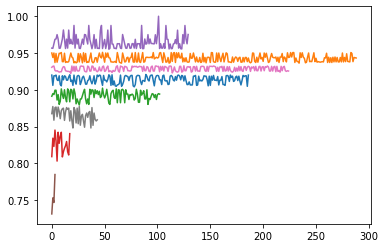

In [10]:
# Generate 1000 coalitions: 
numberOfCoalitions = 1000
PlayersInCoalition = 6
Total_sample = generateCoalitions(PlayersInCoalition,numberOfCoalitions)
VsForCoalitions = []

for i in range(numberOfCoalitions):
    s = get_Vs(Total_sample[i])
    VsForCoalitions.append(s)

clust_x = np.array(VsForCoalitions).reshape(-1,1)
km = KMeans()
n_clusters = 8
y_kmeans = km.fit_predict(clust_x,n_clusters)
Centers_coal = km.cluster_centers_
# Every cluster of coal 
clust_x1 = clust_x[y_kmeans==0]
clust_x2 = clust_x[y_kmeans==1]
clust_x3 = clust_x[y_kmeans==2]
clust_x4 = clust_x[y_kmeans==3]
clust_x5 = clust_x[y_kmeans==4]
clust_x6 = clust_x[y_kmeans==5]
clust_x7 = clust_x[y_kmeans==6]
clust_x8 = clust_x[y_kmeans==7]
clusters = [clust_x1,clust_x2,clust_x3,clust_x4,clust_x5,clust_x6,clust_x7,clust_x8]
plt.plot(clust_x1)
plt.plot(clust_x2)
plt.plot(clust_x3)
plt.plot(clust_x4)
plt.plot(clust_x5)
plt.plot(clust_x6)
plt.plot(clust_x7)
plt.plot(clust_x8)

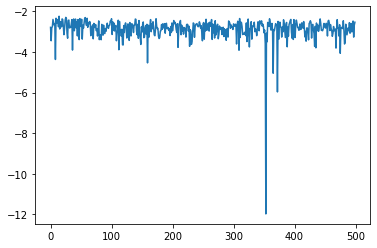

In [11]:
import math
# Iteration for the average distance from center to every point : 
dis_list = []
Max_iter = 500
Average_dis=[]
for i in range(Max_iter):
    New_coals = 100
    c1 = Centers_coal
    PlayersInMewCoalitions = 6
    New_sample = generateCoalitions(PlayersInMewCoalitions,New_coals)
    for k in range(New_coals):
        s = get_Vs(New_sample[k])
        VsForCoalitions.append(s)
        
    clust_x = np.array(VsForCoalitions).reshape(-1,1)
    y_kmeans = km.fit_predict(clust_x)
    Centers_coal = km.cluster_centers_
    d = abs(Centers_coal-c1)
    
# The list of distance     
#     for j in range(len(Centers_coal)):
#         d.append(sum(abs(clusters[j] - Centers_coal[j]))/len(clusters[j] - Centers_coal[j]))
        
#     dis_list.append(d)
#     Average_dis.append(sum(dis_list[i])/len(dis_list[i]))
    Average_dis.append(math.log(sum(d)/len(d)))
plt.plot(np.array(Average_dis).reshape(-1,1))

Try to use 2-d cluster:

In [12]:
total_player_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
def get_coalition(playincoalition):
    coalition = random.sample(range(0,30),playincoalition)
    sup_coalition = list(set(total_player_list) - set(coalition))
    return coalition,sup_coalition


numberOfCoalitions2d = 10000
VsForCoalitions2d = []
for i in range(numberOfCoalitions2d):
    PlayersInCoalition2d = random.randint(0,31)
    coalition,supcoalition = get_coalition(PlayersInCoalition)
    s2d = get_Vs(coalition)
    s2d2 = get_Vs(supcoalition)
    VsForCoalitions2d.append([s2d,s2d2])

cluster_2d_points = np.array(VsForCoalitions2d).reshape(numberOfCoalitions2d,2)    
# plt.scatter(cluster_2d_points[:, 0], cluster_2d_points[:, 1])
# clust_x2d = np.array(VsForCoalitions2d).reshape(-1,1)
# km = KMeans()
# n_clusters = 8
# y_kmeans = km.fit_predict(clust_x,n_clusters)
# Centers_coal = km.cluster_centers_



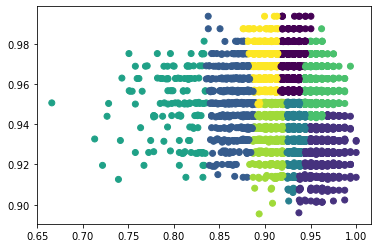

[[0.92937414 0.96487422]
 [0.95989333 0.92749099]
 [0.87086347 0.95230985]
 [0.93397911 0.94062238]
 [0.8010324  0.94948991]
 [0.95258816 0.95656291]
 [0.91003535 0.94142886]
 [0.90335746 0.96502465]]


In [13]:
km2d = KMeans()
y_pred = km2d.fit_predict(cluster_2d_points)
plt.scatter(cluster_2d_points[:, 0], cluster_2d_points[:, 1], c=y_pred)
plt.show()
Centers_coal2d = km2d.cluster_centers_
print(Centers_coal2d)

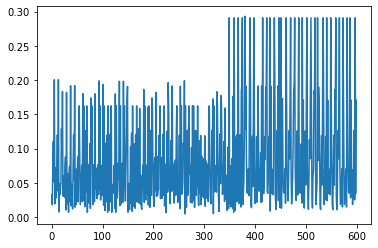

In [16]:
dis_list2d = []
Max_iter2d = 600
Average_dis2d=[]
for i in range(Max_iter2d):
    c12d = Centers_coal2d
    PlayersInnewCoalition2d = random.randint(0,30)
    coalitionnew,supcoalition = get_coalition(PlayersInnewCoalition2d)
    s2dnew = get_Vs(coalitionnew)
    s2dnew_sup = get_Vs(supcoalition)
    VsForCoalitions2d.append([s2dnew,s2dnew_sup])
    
    cluster_2d_points = np.array(VsForCoalitions2d).reshape(len(VsForCoalitions2d),2)
                                                            
                
    y_pred = km2d.fit_predict(cluster_2d_points)
    Centers_coal2d = km2d.cluster_centers_
# The list of distance     
    for j in range(len(Centers_coal2d)):
        dis_list.append(sum(abs(clusters[j] - Centers_coal2d[j]))/len(clusters[j] - Centers_coal2d[j]))
    
    Average_dis2d.append(sum(dis_list[i])/len(dis_list[i]))
plt.plot(np.array(Average_dis2d).reshape(-1,1))

Another item for 2-d 

In [ ]:
total_player_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
def get_coalition(playincoalition):
    coalition = random.sample(range(0,30),playincoalition)
#     sup_coalition = list(set(total_player_list) - set(coalition))
    for i in range(len(coalition)):
        
    return coalition,sup_coalition


numberOfCoalitions2d = 10000
VsForCoalitions2d = []
for i in range(numberOfCoalitions2d):
    PlayersInCoalition2d = random.randint(0,31)
    coalition,supcoalition = get_coalition(PlayersInCoalition)
    s2d = get_Vs(coalition)
    s2d2 = get_Vs(supcoalition)
    VsForCoalitions2d.append([s2d,s2d2])

cluster_2d_points = np.array(VsForCoalitions2d).reshape(numberOfCoalitions2d,2)    

In [25]:
len(Average_dis2d)

50

In [ ]:
Since the one-dimensional clustering was difficult to give us good clustering results in our previous experiments, it made it difficult to continue to improve our algorithm. I added one dimension to our clustering approach, but after some of my experiments, the results showed that it was still not a convergent process. I found the problem that when we build the clustering model for 2^30 coalitions, the randomly generated coalitions are not representative in each iteration, which directly affects the convergence of our algorithm. Moreover, the reason for the non-convergence may also come from the fact that if feature A has a strong influence on the prediction result, the difference between the values of V({A,B,C}) and V({A,B,E,D)} may be small when feature A is involved. (B,C,E,D in this case may not have much influence on the prediction), but if the randomly generated union does not contain A, but is clustered into the same class as {A,B,C} due to the influence of other features, this can lead to an abrupt change in the distance, and thus the algorithm cannot converge.

Translated with www.DeepL.com/Translator (free version)